# GradientBoostingRegressor를 선택  
- 팀원들과 함께 들었던 인터넷 강의에서 배운 알고리즘 Ridge, Lasso, RandomForest, GradientBoostingModel에 대해 자세히 공부해보기로 결정하여 각각 하나씩 맡아 간단한 전처리만 마친 동일한 데이터셋을 활용하여 제출했으나 GBM의 성적이 가장 높아 선택!

# 방향
- 전체 지역을 두고 최적화 했을 때보다 지역별로 모델을 나누어 최적화 했을 때 점수가 더 높았기 때문에 제주, 서귀포, 고산, 성산으로 지역을 나누어 모델링 하였음

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train_new3.csv")
test = pd.read_csv("test_new3.csv")

In [3]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,user6_geton_count,user6_getoff_count,user27_geton_count,user27_getoff_count,user28_geton_count,user28_getoff_count,user29_geton_count,user29_getoff_count,user30_geton_count,user30_getoff_count
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0,0,0,0,0,0,0,0,0,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,user6_geton_count,user6_getoff_count,user27_geton_count,user27_getoff_count,user28_geton_count,user28_getoff_count,user29_geton_count,user29_getoff_count,user30_geton_count,user30_getoff_count
0,415423,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0
1,415424,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,...,0,0,0,0,0,0,0,0,0,0
2,415425,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,415426,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,...,0,0,0,0,0,0,0,0,0,0
4,415427,2019-09-01,4270000,0,1636,롯데호텔,33.24872,126.41032,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.shape, test.shape

((415423, 55), (228170, 54))

# RMSE 구현하기  
- 대회의 Evaluation 방식이 RMSE  
- 이 수치가 높다고 해서 파라미터가 좋다고 확신할 수는 없지만 Feature를 고르는 데에 도움이 된다

In [6]:
def rmse(predicted_values, actual_values):
    score = np.sqrt(((predicted_values - actual_values)**2).mean())
    return score

# 1. Jeju  

In [7]:
train_jeju = train.loc[train['location_name'] == 'jeju']
test_jeju = test.loc[test['location_name'] == 'jeju']

train_jeju.shape, test_jeju.shape

((250509, 55), (136784, 54))

In [8]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_jeju[input_var]
y_train = train_jeju[target]
X_test=test_jeju[input_var]

X_train.shape, y_train.shape, X_test.shape

((250509, 38), (250509,), (136784, 38))

## 1.1. 최적의 파라미터 구하기
- random sampling을 이용함  

In [9]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((2505, 38), (2505,))

In [11]:
param_grid = {
    'max_features': ['sqrt',10, 14],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'max_depth': [5,6,7,8],
    'subsample': [0.75,0.8,0.85]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'subsample': 0.85}

#### Scale을 높여서 다시 GridSearch

In [15]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.2,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((50102, 38), (50102,))

In [16]:
param_grid = {
    'max_depth': [5,6,7,8],
    'subsample': [0.8,0.85,0.9]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_features='sqrt',
                                min_samples_leaf= 2, min_samples_split= 6, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_depth': 8, 'subsample': 0.9}

## 1.2. 불필요한 Feature 제거하기  
- 전체 Feature를 넣고 제출했을 때보다 RMSE 결과가 개선된 방향으로 feature를 빼줬더니 점수가 올랐기 때문에 불필요한 것은 제거해주기로 함

#### Baseline

In [17]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_jeju[input_var]
y_train = train_jeju[target]
X_test=test_jeju[input_var]

X_train.shape, y_train.shape, X_test.shape

((250509, 38), (250509,), (136784, 38))

Score:  2.155101659654403


Text(0, 0.5, 'Feature Importance Score')

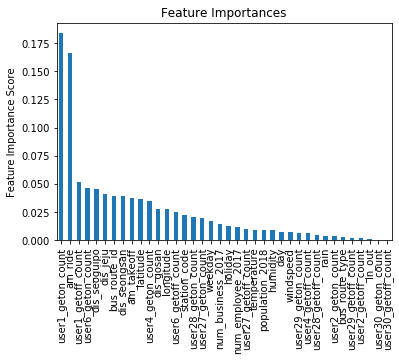

In [18]:
gbm0 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth= 8, max_features= 'sqrt',
                                 min_samples_leaf= 2, min_samples_split= 6, subsample= 0.9, random_state=43)

gbm0.fit(X_train, y_train)
preds = gbm0.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm0.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_getoff_count 빼기

In [19]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_jeju[input_var]
y_train = train_jeju[target]
X_test=test_jeju[input_var]

X_train.shape, y_train.shape, X_test.shape

((250509, 37), (250509,), (136784, 37))

Score:  2.14759061293648


Text(0, 0.5, 'Feature Importance Score')

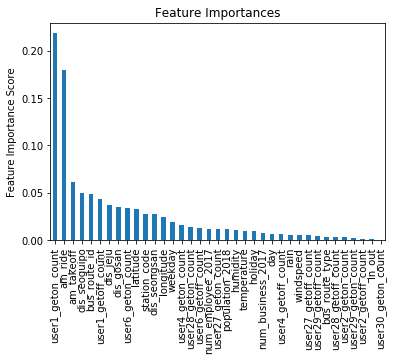

In [20]:
gbm0 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth= 8, max_features= 'sqrt',
                                 min_samples_leaf= 2, min_samples_split= 6, subsample= 0.9, random_state=43)

gbm0.fit(X_train, y_train)
preds = gbm0.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm0.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_getoff_count, user30_geton_count 빼주기

In [21]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_jeju[input_var]
y_train = train_jeju[target]
X_test=test_jeju[input_var]

X_train.shape, y_train.shape, X_test.shape

((250509, 36), (250509,), (136784, 36))

Score:  2.157603686184056


Text(0, 0.5, 'Feature Importance Score')

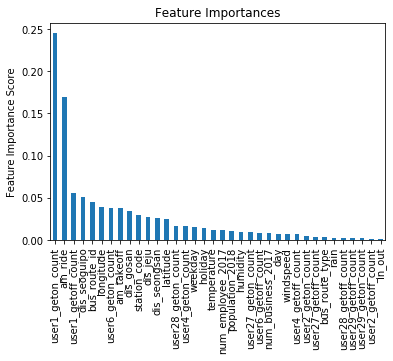

In [22]:
gbm0 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth= 8, max_features= 'sqrt',
                                 min_samples_leaf= 2, min_samples_split= 6, subsample= 0.9, random_state=43)

gbm0.fit(X_train, y_train)
preds = gbm0.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm0.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

- user30_getoff_count만 빼주기로 한다

## 1.3 최적의 결과 test_jeju에 적용

In [23]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_jeju[input_var]
y_train = train_jeju[target]
X_test=test_jeju[input_var]

X_train.shape, y_train.shape, X_test.shape

((250509, 37), (250509,), (136784, 37))

Score:  2.14759061293648


Text(0, 0.5, 'Feature Importance Score')

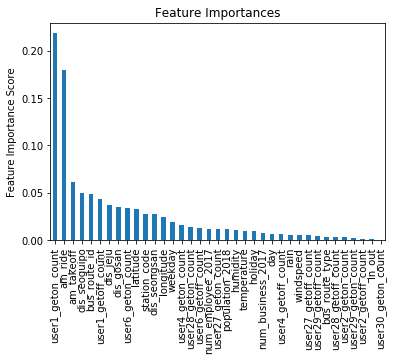

In [24]:
gbm0 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth= 8, max_features= 'sqrt',
                                 min_samples_leaf= 2, min_samples_split= 6, subsample= 0.9, random_state=43)

gbm0.fit(X_train, y_train)
preds = gbm0.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm0.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [25]:
test_jeju['18~20_ride'] = gbm0.predict(X_test)
test_jeju = test_jeju[['id', '18~20_ride']]
test_jeju.head()

,id,18~20_ride
0,415423,1.634272
1,415424,4.181670
2,415425,0.908170
3,415426,18.861597
26,415449,0.194678


In [26]:
test_jeju.shape

(136784, 2)

# 2. Seoguipo

In [27]:
train_seoguipo = train.loc[train['location_name'] == 'seoguipo']
test_seoguipo = test.loc[test['location_name'] == 'seoguipo']

train_seoguipo.shape, test_seoguipo.shape

((91237, 55), (50632, 54))

In [28]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seoguipo[input_var]
y_train = train_seoguipo[target]
X_test=test_seoguipo[input_var]

X_train.shape, y_train.shape, X_test.shape

((91237, 38), (91237,), (50632, 38))

## 2.1. 최적의 파라미터 구하기

In [29]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((912, 38), (912,))

In [30]:
param_grid = {
    'max_features': ['sqrt',10, 14],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'max_depth': [5,6,7,8],
    'subsample': [0.75,0.8,0.85]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_depth': 8,
 'max_features': 14,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'subsample': 0.85}

#### scale 높여서 다시 GridSearch

In [33]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.2,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((18247, 38), (18247,))

In [34]:
param_grid = {
    'max_features': ['sqrt',10, 14],
    'subsample': [0.75,0.8,0.85]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=8, 
                                min_samples_leaf=2, min_samples_split=2, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_features': 10, 'subsample': 0.8}

## 2.2. 불필요한 Feature 제거하기

#### Baseline

In [35]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seoguipo[input_var]
y_train = train_seoguipo[target]
X_test=test_seoguipo[input_var]

X_train.shape, y_train.shape, X_test.shape

((91237, 38), (91237,), (50632, 38))

Score:  0.9334942391017732


Text(0, 0.5, 'Feature Importance Score')

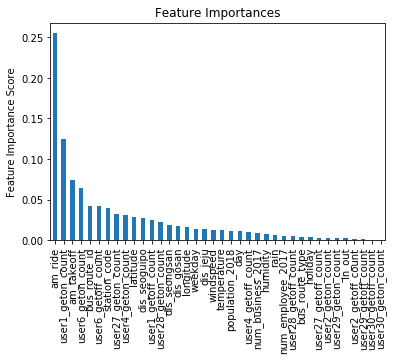

In [36]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=8, max_features= 10,
                                 min_samples_leaf=2, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm1.fit(X_train, y_train)
preds = gbm1.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm1.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_geton_count 제거

In [37]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seoguipo[input_var]
y_train = train_seoguipo[target]
X_test=test_seoguipo[input_var]

X_train.shape, y_train.shape, X_test.shape

((91237, 37), (91237,), (50632, 37))

Score:  0.9307014778442805


Text(0, 0.5, 'Feature Importance Score')

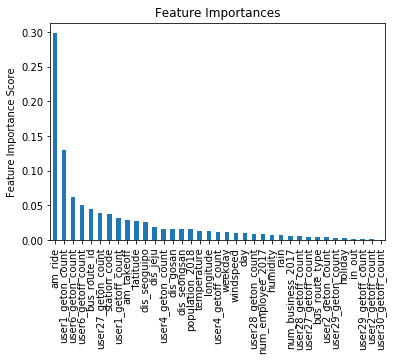

In [38]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=8, max_features= 10,
                                 min_samples_leaf=2, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm1.fit(X_train, y_train)
preds = gbm1.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm1.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_geton_count, user30_getoff_count 제거

In [39]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seoguipo[input_var]
y_train = train_seoguipo[target]
X_test=test_seoguipo[input_var]

X_train.shape, y_train.shape, X_test.shape

((91237, 36), (91237,), (50632, 36))

Score:  0.9179021269378268


Text(0, 0.5, 'Feature Importance Score')

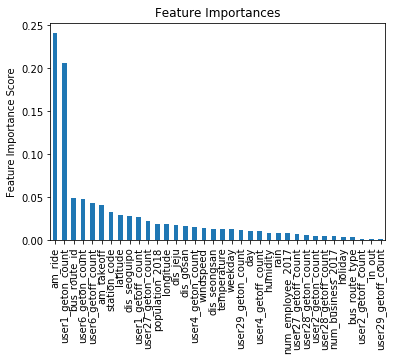

In [40]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=8, max_features= 10,
                                 min_samples_leaf=2, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm1.fit(X_train, y_train)
preds = gbm1.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm1.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_geton_count, user30_getoff_count, user29_getoff_count 제거

In [41]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seoguipo[input_var]
y_train = train_seoguipo[target]
X_test=test_seoguipo[input_var]

X_train.shape, y_train.shape, X_test.shape

((91237, 35), (91237,), (50632, 35))

Score:  0.9306898269458015


Text(0, 0.5, 'Feature Importance Score')

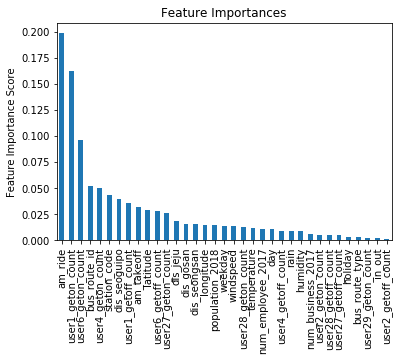

In [42]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=8, max_features= 10,
                                 min_samples_leaf=2, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm1.fit(X_train, y_train)
preds = gbm1.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm1.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

- user30_geton_count, user30_getoff_count만 제거하기로 한다

## 2.3. 최적의 결과 test_seoguipo에 적용

In [43]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seoguipo[input_var]
y_train = train_seoguipo[target]
X_test=test_seoguipo[input_var]

X_train.shape, y_train.shape, X_test.shape

((91237, 36), (91237,), (50632, 36))

Score:  0.9179021269378268


Text(0, 0.5, 'Feature Importance Score')

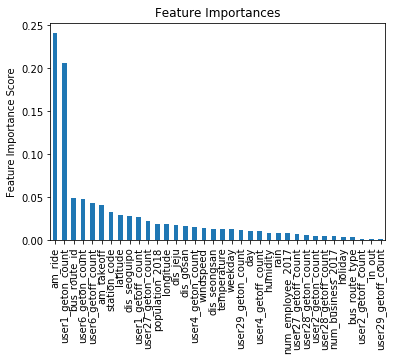

In [44]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=8, max_features= 10,
                                 min_samples_leaf=2, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm1.fit(X_train, y_train)
preds = gbm1.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm1.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [45]:
test_seoguipo['18~20_ride'] = gbm1.predict(X_test)
test_seoguipo = test_seoguipo[['id','18~20_ride']]
test_seoguipo.head()

,id,18~20_ride
4,415427,1.428282
5,415428,1.034380
6,415429,0.429903
7,415430,3.377269
8,415431,1.655392


In [46]:
test_seoguipo.shape

(50632, 2)

# 3. Gosan

In [47]:
train_gosan = train.loc[train['location_name'] == 'gosan']
test_gosan = test.loc[test['location_name'] == 'gosan']

train_gosan.shape, test_gosan.shape

((37327, 55), (20700, 54))

In [48]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_gosan[input_var]
y_train = train_gosan[target]
X_test=test_gosan[input_var]

X_train.shape, y_train.shape, X_test.shape

((37327, 38), (37327,), (20700, 38))

## 3.1. 최적의 파라미터 구하기  
- 이전에 최적의 n_estimators가 200이상이었으므로 learning_rate 상향조정함

In [50]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.05,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((1866, 38), (1866,))

In [51]:
param_grid = {
    'max_features': ['sqrt',10, 14],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'max_depth': [5,6,7,8],
    'subsample': [0.75,0.8,0.85]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'subsample': 0.85}

In [52]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.5,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((18664, 38), (18664,))

In [53]:
param_grid = {
    'max_depth': [5,6,7,8],
    'subsample': [0.75,0.8,0.85]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_features='sqrt',
                                min_samples_leaf=3, min_samples_split=2, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_depth': 8, 'subsample': 0.8}

## 3.2. 불필요한 Feature 제거하기

#### Baseline

In [54]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_gosan[input_var]
y_train = train_gosan[target]
X_test=test_gosan[input_var]

X_train.shape, y_train.shape, X_test.shape

((37327, 38), (37327,), (20700, 38))

Score:  0.7075152279593182


Text(0, 0.5, 'Feature Importance Score')

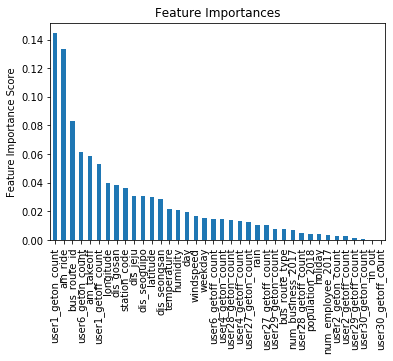

In [55]:
gbm2 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=8 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm2.fit(X_train, y_train)
preds = gbm2.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm2.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_getoff_count 제거

In [56]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_gosan[input_var]
y_train = train_gosan[target]
X_test=test_gosan[input_var]

X_train.shape, y_train.shape, X_test.shape

((37327, 37), (37327,), (20700, 37))

Score:  0.6852453191613508


Text(0, 0.5, 'Feature Importance Score')

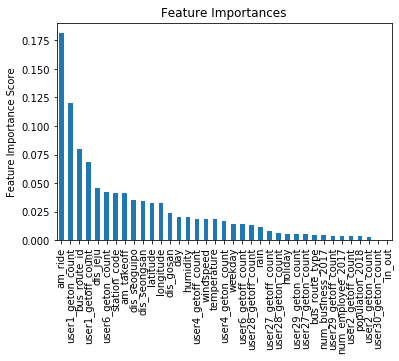

In [57]:
gbm2 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=8 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm2.fit(X_train, y_train)
preds = gbm2.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm2.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_getoff_count, in_out 제거

In [58]:
input_var = [
       'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_gosan[input_var]
y_train = train_gosan[target]
X_test=test_gosan[input_var]

X_train.shape, y_train.shape, X_test.shape

((37327, 36), (37327,), (20700, 36))

Score:  0.6856036170406876


Text(0, 0.5, 'Feature Importance Score')

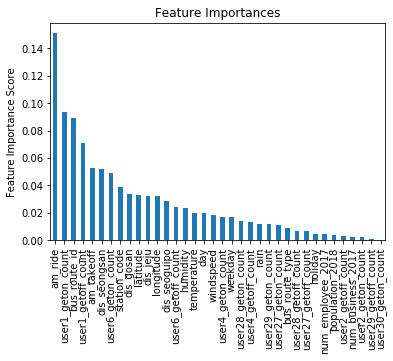

In [59]:
gbm2 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=8 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm2.fit(X_train, y_train)
preds = gbm2.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm2.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

- user30_getoff_count만 제거해주기로 한다

## 3.3. 최적의 결과 test_gosan에 적용

In [60]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_gosan[input_var]
y_train = train_gosan[target]
X_test=test_gosan[input_var]

X_train.shape, y_train.shape, X_test.shape

((37327, 37), (37327,), (20700, 37))

Score:  0.6852453191613508


Text(0, 0.5, 'Feature Importance Score')

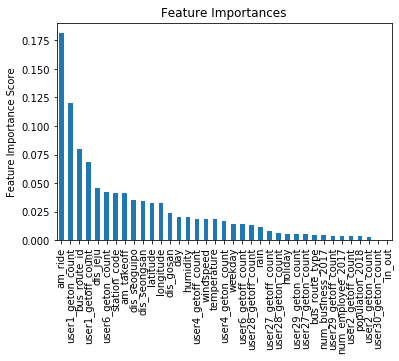

In [61]:
gbm2 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=8 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split= 2, subsample= 0.8, random_state=43)

gbm2.fit(X_train, y_train)
preds = gbm2.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm2.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [62]:
test_gosan['18~20_ride'] = gbm2.predict(X_test)
test_gosan = test_gosan[['id', '18~20_ride']]
test_gosan.head()

,id,18~20_ride
19,415442,1.996171
50,415473,3.651787
72,415495,1.107652
183,415606,0.398969
184,415607,1.054893


In [63]:
test_gosan.shape

(20700, 2)

# 4. Seongsan

In [64]:
train_seongsan = train.loc[train['location_name'] == 'seongsan']
test_seongsan = test.loc[test['location_name'] == 'seongsan']

train_seongsan.shape, test_seongsan.shape

((36350, 55), (20054, 54))

In [65]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seongsan[input_var]
y_train = train_seongsan[target]
X_test=test_seongsan[input_var]

X_train.shape, y_train.shape, X_test.shape

((36350, 38), (36350,), (20054, 38))

## 4.1. 최적의 파라미터 구하기

In [66]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.05,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((1818, 38), (1818,))

In [67]:
param_grid = {
    'max_features': ['sqrt',10, 14],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'max_depth': [5,6,7,8],
    'subsample': [0.75,0.8,0.85]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'subsample': 0.85}

In [68]:
random.seed(43)
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.5,0)))

X_train_sample = X_train.iloc[train_list]
y_train_sample = y_train.iloc[train_list]

X_train_sample.shape, y_train_sample.shape

((18175, 38), (18175,))

In [69]:
param_grid = {
    'max_depth': [5,6,7,8],
    'subsample': [0.75,0.8,0.85]
}

# Create a baseline model
gbm = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_features='sqrt',
                                min_samples_leaf=3, min_samples_split=2, random_state=43)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, cv=5)
grid_search.fit(X_train_sample, y_train_sample)

grid_search.best_params_ 

{'max_depth': 7, 'subsample': 0.85}

## 4.2. 불필요한 Feature 제거하기

#### Baseline

In [70]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 'user30_getoff_count',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seongsan[input_var]
y_train = train_seongsan[target]
X_test=test_seongsan[input_var]

X_train.shape, y_train.shape, X_test.shape

((36350, 38), (36350,), (20054, 38))

Score:  0.7821288674243823


Text(0, 0.5, 'Feature Importance Score')

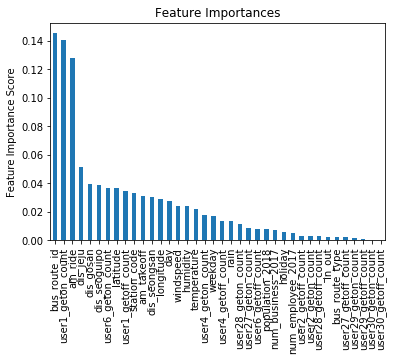

In [71]:
gbm3 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=7 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split=2, subsample= 0.85, random_state=43)

gbm3.fit(X_train, y_train)
preds = gbm3.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm3.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_getoff_count 제거

In [72]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count', 'user30_geton_count', 
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seongsan[input_var]
y_train = train_seongsan[target]
X_test=test_seongsan[input_var]

X_train.shape, y_train.shape, X_test.shape

((36350, 37), (36350,), (20054, 37))

Score:  0.7798174489268013


Text(0, 0.5, 'Feature Importance Score')

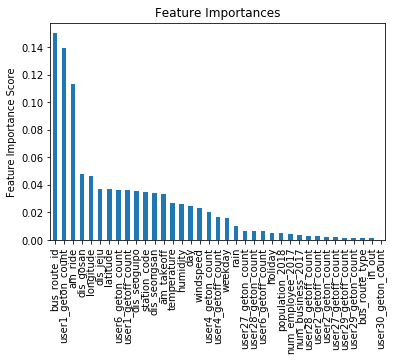

In [73]:
gbm3 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=7 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split=2, subsample= 0.85, random_state=43)

gbm3.fit(X_train, y_train)
preds = gbm3.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm3.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_getoff_count, user30_geton_count 제거

In [74]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count',  
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seongsan[input_var]
y_train = train_seongsan[target]
X_test=test_seongsan[input_var]

X_train.shape, y_train.shape, X_test.shape

((36350, 36), (36350,), (20054, 36))

Score:  0.7720029400650233


Text(0, 0.5, 'Feature Importance Score')

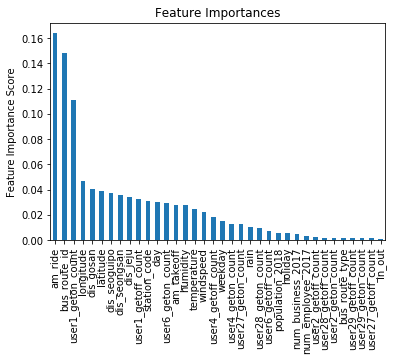

In [75]:
gbm3 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=7 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split=2, subsample= 0.85, random_state=43)

gbm3.fit(X_train, y_train)
preds = gbm3.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm3.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### user30_getoff_count, user30_geton_count, in_out 제거

In [76]:
input_var = [
       'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count',  
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seongsan[input_var]
y_train = train_seongsan[target]
X_test=test_seongsan[input_var]

X_train.shape, y_train.shape, X_test.shape

((36350, 35), (36350,), (20054, 35))

Score:  0.7989085124947168


Text(0, 0.5, 'Feature Importance Score')

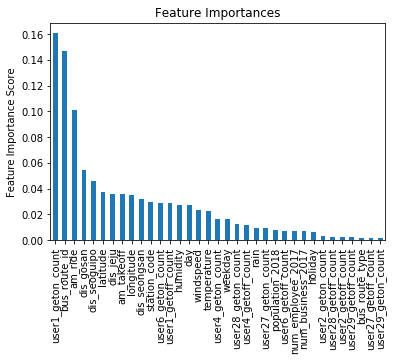

In [77]:
gbm3 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=7 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split=2, subsample= 0.85, random_state=43)

gbm3.fit(X_train, y_train)
preds = gbm3.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm3.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

- user30_getoff_count, user30_geton_count만 제거하기로 한다

## 4.3. 최적의 결과 test_seongsan에 적용

In [78]:
input_var = [
       'in_out', 'bus_route_id', 'station_code', 
       'latitude', 'longitude', 'weekday', 
       'bus_route_type', 'holiday', 'temperature', 'rain',
       'windspeed', 'humidity', 'num_business_2017', 'num_employee_2017',
       'population_2018', 'day', 'am_ride', 'am_takeoff', 'user1_geton_count',
       'user1_getoff_count', 'user2_geton_count', 'user2_getoff_count',
       'user4_geton_count', 'user4_getoff_count', 'user6_geton_count',
       'user6_getoff_count', 'user27_geton_count', 'user27_getoff_count',
       'user28_geton_count', 'user28_getoff_count', 'user29_geton_count',
       'user29_getoff_count',  
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_seoguipo'
]

target='18~20_ride'

X_train = train_seongsan[input_var]
y_train = train_seongsan[target]
X_test=test_seongsan[input_var]

X_train.shape, y_train.shape, X_test.shape

((36350, 36), (36350,), (20054, 36))

Score:  0.7720029400650233


Text(0, 0.5, 'Feature Importance Score')

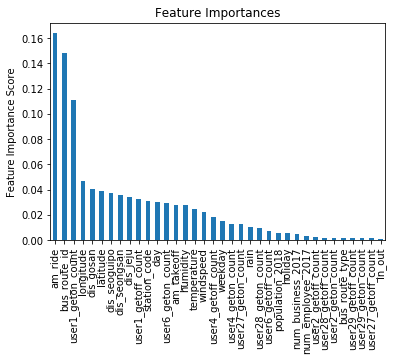

In [79]:
gbm3 = GradientBoostingRegressor(learning_rate=0.12, n_estimators=200, max_depth=7 , max_features= 'sqrt',
                                 min_samples_leaf= 3, min_samples_split=2, subsample= 0.85, random_state=43)

gbm3.fit(X_train, y_train)
preds = gbm3.predict(X_train)
score = rmse(y_train,preds)
print ("Score: ", score)

feat_imp = pd.Series(gbm3.feature_importances_, input_var).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [80]:
test_seongsan['18~20_ride'] = gbm3.predict(X_test)
test_seongsan = test_seongsan[['id', '18~20_ride']]
test_seongsan.head()

,id,18~20_ride
105,415528,-0.621183
106,415529,0.081797
116,415539,2.114192
117,415540,2.297464
119,415542,1.560910


In [81]:
test_seongsan.shape

(20054, 2)

# 지역별 결과 합치기

In [82]:
test_jeju.shape, test_seoguipo.shape, test_gosan.shape, test_seongsan.shape

((136784, 2), (50632, 2), (20700, 2), (20054, 2))

In [83]:
result = pd.concat([test_jeju, test_seoguipo, test_gosan, test_seongsan])
result.shape

(228170, 2)

In [84]:
sample = pd.read_csv("submission_sample.csv")
del sample['18~20_ride']

#### id순서를 sample에 맞추기 위해 sample에 merge

In [85]:
final = pd.merge(sample, result, how='left', on='id')
final.head()

,id,18~20_ride
0,415423,1.634272
1,415424,4.181670
2,415425,0.908170
3,415426,18.861597
4,415427,1.428282


In [86]:
final.shape

(228170, 2)

In [87]:
final.isnull().sum()

id            0
18~20_ride    0
dtype: int64

In [88]:
final.to_csv("submission_best.csv", index=False)

In [89]:
final = pd.read_csv("submission_best.csv")

In [90]:
final.head()

,id,18~20_ride
0,415423,1.634272
1,415424,4.181670
2,415425,0.908170
3,415426,18.861597
4,415427,1.428282


In [91]:
final.shape

(228170, 2)

- 모든 지역의 파라미터를 `learning_rate=0.1, n_estimators=200` 으로 통일하고 돌렸을 때 점수는 2.419556473 이었는데 각 지역 별로 `learning_rate` 조정해주었더니 점수가 2.419400983으로 올랐다!  